#  Libraries

In [1]:
import pandas as pd
#import functions as f
#import holidays as h
import os
import pickle
import time
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from string import punctuation
import pandas as pd
import numpy as np
from itertools import product
import datetime

In [3]:
import xgboost as xgb
import time
import warnings

import pickle
from xgboost import plot_importance
warnings.filterwarnings('ignore')

# Functions

## Item Category

In [4]:
def correct_item_category_name(df):
    'adjust the format of the "item_category_name" column'
    df.loc[df['item_category_name'] == 'Билеты (Цифра)','item_category_name'] = 'Билеты - Цифра'
    df.loc[df['item_category_name'] == 'Доставка товара','item_category_name'] = 'Доставка товара - service'
    df.loc[df['item_category_name'] == 'Карты оплаты (Кино, Музыка, Игры)',
           'item_category_name'] = 'Карты оплаты - Кино, Музыка, Игры'
    df.loc[df['item_category_name'] == 'Служебные','item_category_name'] = 'Служебные - none'
    df.loc[df['item_category_name'] == 'Чистые носители (шпиль)','item_category_name'] = 'Чистые носители - шпиль'
    df.loc[df['item_category_name'] == 'Чистые носители (штучные)','item_category_name'] = 'Чистые носители - штучные'
    df.loc[df['item_category_name'] == 'Элементы питания','item_category_name'] = 'Элементы питания - none'
    
    return df


def extract_main_category(df):
    df['item_category_main'] = df['item_category_name'].str.split(' - ').str[0]

    le = preprocessing.LabelEncoder()
    df['item_category_main'] = le.fit_transform(df['item_category_main'])

    return df

def extract_whether_digital(df):
    df['is_category_digital'] = 0
    df.loc[df['item_category_name'].str.contains('Цифра'),'is_category_digital'] = 1
    
    return df

def extract_ps_related(df):
    df['is_category_ps_related'] = 0
    df.loc[df['item_category_name'].str.contains('PS'),'is_category_ps_related'] = 1
    
    return df

def fix_item_category(df):
    df = correct_item_category_name(df)
    df = extract_main_category(df)
    df = extract_whether_digital(df)
    df = extract_ps_related(df)
    df.drop(columns = ['item_category_name'], inplace = True)
    
    return df

## Sales

In [5]:
def prepare_sales_montly(sales):
    
    sales_train_df_no_dupl_shops = adjust_duplicated_shops(sales)
    
    sales_train_montly_df = sales_train_df_no_dupl_shops.groupby(
        ['date_block_num','shop_id','item_id'])['item_price','item_cnt_day','date'].agg(
                        {'item_price':'mean',
                        'date':'min',
                        'item_cnt_day':'sum'})
    sales_train_montly_df = sales_train_montly_df.reset_index()

    colnames = ['date_block_num', 'shop_id', 'item_id', 'item_price_avg','date_min','item_cnt_month']
    sales_train_montly_df.columns = colnames
    
    return sales_train_montly_df



def remove_outliers(df):
    return df[(df["item_price"] < np.percentile(df["item_price"], q=99))
              & (df["item_price"] > 0)
              & (df["item_cnt_day"] >= 0)
              & (df["item_cnt_day"] < np.percentile(df["item_cnt_day"], q=99))]


def adjust_duplicated_shops(df):
    'Function that combines duplicated shop names'
    # from https://www.kaggle.com/taranenkodaria/predict-future-sales-the-russian-forecast
    # Test Set unique shop_id --> we should only use these ids
    # array([ 2,  3,  4,  5,  6,  7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25,
    #   26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49,
    #   50, 52, 53, 55, 56, 57, 58, 59], dtype=int64)
    
    df.loc[df['shop_id'] == 0, 'shop_id'] = 57
    df.loc[df['shop_id'] == 1, 'shop_id'] = 58
    df.loc[df['shop_id'] == 11, 'shop_id'] = 10
    df.loc[df['shop_id'] == 40, 'shop_id'] = 39
    df.loc[df['shop_id'] == 23, 'shop_id'] = 24
    
    return df

## shops

In [6]:
def extract_shop_type(df):
    'Extracts type of the shop and creates the shop_type_1 and shop_type_2 columns'
    
    df['shop_type_1'] = 'NONE'
    df['shop_type_2'] = 'NONE'
    
    df.loc[df['shop_name'].str.contains('ТЦ'),'shop_type_1'] = 'type_1'
    df.loc[df['shop_name'].str.contains('ТК'),'shop_type_1'] = 'type_2'
    df.loc[df['shop_name'].str.contains('ТРЦ'),'shop_type_1'] = 'type_3'
    df.loc[df['shop_name'].str.contains('ТРК'),'shop_type_1'] = 'type_4' 
    
    df.loc[(df['shop_name'].str.contains('ТЦ')) |
           (df['shop_name'].str.contains('ТК')),'shop_type_2'] = 'type_1'
    df.loc[(df['shop_name'].str.contains('ТРЦ')) |
           (df['shop_name'].str.contains('ТРК')),'shop_type_2'] = 'type_2'
    
    le_1 = preprocessing.LabelEncoder()
    df['shop_type_1'] = le_1.fit_transform(df['shop_type_1'])
    le_2 = preprocessing.LabelEncoder()
    df['shop_type_2'] = le_2.fit_transform(df['shop_type_2'])
    
    return df

def extract_shop_city(df):
    'Extracts shop city name and city type and creates two new columns'
    
    # City type: 1 if city is Moscow or Sankt Petersburg (they are quite different from the rest of Russia)
    df['shop_city_type'] = 0
    
    df['shop_city'] = df['shop_name'].str.split(' ').str[0]
    df.loc[df['shop_city'].isin(['Москва','СПб']),'shop_city_type'] = 1
    
    le = preprocessing.LabelEncoder()
    df['shop_city'] = le.fit_transform(df['shop_city'])
    
    return df


def fix_shops(shops_df):
    """
    This function modifies the shops df inplace.
    It correct's 3 shops that we have found to be 'duplicates'
    and also creates a few more features: extracts the city and encodes it using LabelEncoder
    """
    
    shops_df = shops_df.loc[~shops_df['shop_id'].isin([0, 1, 11, 40, 23])]
    shops_df = extract_shop_type(shops_df)
    shops_df = extract_shop_city(shops_df)
    shops_df.drop(columns = ['shop_name'], inplace = True)

    return shops_df

## Matrix

In [7]:
def create_matrix(df):
    x = datetime.date(2013, 1, 1)
    matrix = []
    cols = ["date_block_num", "shop_id", "item_id", "Year", "Month"]
    for i in range(34):
        try:
            sales = df[df.date_block_num == i]
            matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique(), [x.year], [x.month])), dtype=np.int16))
            x = x.replace(month=x.month+1)
        except ValueError:
            if x.month == 12:
                x = x.replace(year=x.year+1, month=1)
            else:
                # next month is too short to have "same date"
                # pick your own heuristic, or re-raise the exception:
                raise

    matrix = pd.DataFrame(np.vstack(matrix), columns = cols )
    matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
    matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
    matrix["item_id"] = matrix["item_id"].astype(np.int16)
    matrix.sort_values(cols, inplace=True)

    return matrix


def add_zero_sales(df, matrix):
    if matrix is None:
        matrix = create_matrix(df)
    #df.drop(columns = ['date_min'], inplace = True)
    df = pd.merge(matrix, df, how='left',
                  left_on=['date_block_num', 'shop_id', 'item_id'],
                  right_on=['date_block_num', 'shop_id', 'item_id'])

    return df

## Russian Hollidays

In [8]:
russian_holidays_start = [
    datetime.date(2013, 1, 1),
    datetime.date(2013, 2, 23),
    datetime.date(2013, 3, 8),
    datetime.date(2013, 5, 1),
    datetime.date(2013, 5, 9),
    datetime.date(2013, 6, 12),
    datetime.date(2013, 11, 4),

    datetime.date(2014, 1, 1),
    datetime.date(2014, 2, 23),
    datetime.date(2014, 3, 8),
    datetime.date(2014, 5, 1),
    datetime.date(2014, 5, 9),
    datetime.date(2014, 6, 12),
    datetime.date(2014, 11, 4),

    datetime.date(2015, 1, 1),
    datetime.date(2015, 2, 23),
    datetime.date(2015, 3, 8),
    datetime.date(2015, 5, 1),
    datetime.date(2015, 5, 9),
    datetime.date(2015, 6, 12),
    datetime.date(2015, 11, 4)
]

russian_holidays_end = [
    datetime.date(2013, 1, 8),
    datetime.date(2013, 2, 23),
    datetime.date(2013, 3, 8),
    datetime.date(2013, 5, 1),
    datetime.date(2013, 5, 9),
    datetime.date(2013, 6, 12),
    datetime.date(2013, 11, 4),

    datetime.date(2014, 1, 8),
    datetime.date(2014, 2, 23),
    datetime.date(2014, 3, 8),
    datetime.date(2014, 5, 1),
    datetime.date(2014, 5, 9),
    datetime.date(2014, 6, 12),
    datetime.date(2014, 11, 4),

    datetime.date(2015, 1, 8),
    datetime.date(2015, 2, 23),
    datetime.date(2015, 3, 8),
    datetime.date(2015, 5, 1),
    datetime.date(2015, 5, 9),
    datetime.date(2015, 6, 12),
    datetime.date(2015, 11, 4)
]


def russian_holidays():
    holidays = pd.DataFrame(columns=['Year', 'Month', 'holidays'])

    for start_date, end_date in zip(russian_holidays_start, russian_holidays_end):
        holidays = holidays.append(
            {'Year': start_date.year, 'Month': start_date.month, 'holidays': (end_date - start_date).days + 1},
            ignore_index=True)
    holidays['Year'] = holidays['Year'].astype('int64')
    holidays['Month'] = holidays['Month'].astype('int64')
    return holidays


def add_holidays(final_df):
    final_df = pd.merge(final_df, russian_holidays(),  how='left', left_on=['Year', 'Month'], right_on=['Year', 'Month'])
    return final_df.drop_duplicates()

## Train DF

In [9]:
def prepare_sales():
    # load and preprocess sales
    sales = pd.read_csv("competitive-data-science-predict-future-sales/sales_train.csv")
    sales = remove_outliers(sales)
    sales = prepare_sales_montly(sales)
    # matrix 
    matrix = create_matrix(sales)
    sales_transformed = add_zero_sales(sales, matrix)
    
    return sales_transformed

def create_train_df(sales):
    """
    This is a helper function that creates the train df.
    """
    # load shops and preprocess it
    shops = pd.read_csv("competitive-data-science-predict-future-sales/shops.csv")
    shops = fix_shops(shops)  # fix the shops as we have seen before
    
    # load item_category and preprocess it
    items_category = pd.read_csv("competitive-data-science-predict-future-sales/item_categories.csv")
    items_category = fix_item_category(items_category)
    
    # load items
    items = pd.read_csv("competitive-data-science-predict-future-sales/items.csv")
    items.drop(columns = ['item_name'], inplace = True)
    
    # merge data
    items_to_merge = items.merge(items_category, on = 'item_category_id')
    merged_df = sales.merge(shops, on = 'shop_id', how = 'left')
    merged_df = merged_df.merge(items_to_merge, on = 'item_id', how = 'left')
    merged_df = add_previous_months_sales(merged_df)
    
    merged_df = remove_nan(merged_df)
    #merged_df = calculate_missing_prices_for_train_set(merged_df)
    
    #merged_df = downcast_dtypes(merged_df)
    
    return merged_df


def add_previous_months_sales(origin_df, list_lags=None):
    if list_lags is None:
        list_lags = [1, 2, 3]

    final_df = origin_df.copy()

    for month_shift in list_lags:
        shifted = origin_df.copy()
        shifted = shifted[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']]
        shifted.date_block_num = shifted.date_block_num + month_shift
        shifted.rename(columns={"item_cnt_month": "item_cnt_month_"+str(month_shift)}, inplace=True)
        final_df = pd.merge(final_df, shifted,  how='left', left_on=['date_block_num', 'shop_id', 'item_id'],
                            right_on=['date_block_num', 'shop_id', 'item_id'])
    del shifted

    return final_df.drop_duplicates()


def remove_nan(df):
    df['item_cnt_month'] = df['item_cnt_month'].fillna(0)
    df['item_cnt_month_1'] = df['item_cnt_month_1'].fillna(0)
    df['item_cnt_month_2'] = df['item_cnt_month_2'].fillna(0)
    df['item_cnt_month_3'] = df['item_cnt_month_3'].fillna(0)
    #df['holidays'] = df['holidays'].fillna(0)
    df.drop(columns = ['date_min'], inplace = True)
    
    return df

def downcast_dtypes(df):
    """
        Changes column types in the dataframe:

                `float64` type to `float32`
                `int64`   type to `int32`
    """

    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype == "int64"]

    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int32)

    return df

def calculate_missing_prices_for_train_set(df):
    average_price = df.sort_values(['date_block_num']).dropna(subset = ['item_price_avg'])
    average_price = average_price.drop_duplicates(subset = ['item_id'], keep = 'last')[['item_id','item_price_avg']]


    train_df_is_null = df.loc[df['item_price_avg'].isnull()]
    train_df_is_null.drop(columns = ['item_price_avg'], inplace = True)
    train_df_is_null = train_df_is_null.merge(average_price, on = 'item_id', how = 'left')

    train_df_is_not_null = df.loc[~train_df['item_price_avg'].isnull()]

    train_df_final = pd.concat([train_df_is_null, train_df_is_not_null], axis = 0)
    
    return train_df_final

In [10]:
sales = prepare_sales()

In [11]:
train_df = create_train_df(sales)
train_df = calculate_missing_prices_for_train_set(train_df)
train_df = downcast_dtypes(train_df)

In [12]:
train_df.shape

(10685502, 18)

In [13]:
train_df.isnull().mean()

Month                     0.0
Year                      0.0
date_block_num            0.0
is_category_digital       0.0
is_category_ps_related    0.0
item_category_id          0.0
item_category_main        0.0
item_cnt_month            0.0
item_cnt_month_1          0.0
item_cnt_month_2          0.0
item_cnt_month_3          0.0
item_id                   0.0
item_price_avg            0.0
shop_city                 0.0
shop_city_type            0.0
shop_id                   0.0
shop_type_1               0.0
shop_type_2               0.0
dtype: float64

In [190]:
train_df.head()

,Month,Year,date_block_num,is_category_digital,is_category_ps_related,item_category_id,item_category_main,item_cnt_month,item_cnt_month_1,item_cnt_month_2,item_cnt_month_3,item_id,item_price_avg,shop_city,shop_city_type,shop_id,shop_type_1,shop_type_2
0,1,2013,0,0,0,40,10,0.0,0.0,0.0,0.0,19,28.0,0,0,2,1,1
1,1,2013,0,0,0,30,8,0.0,0.0,0.0,0.0,28,199.0,0,0,2,1,1
2,1,2013,0,0,0,23,5,0.0,0.0,0.0,0.0,29,1198.0,0,0,2,1,1
3,1,2013,0,0,0,40,10,0.0,0.0,0.0,0.0,32,149.0,0,0,2,1,1
4,1,2013,0,0,0,40,10,0.0,0.0,0.0,0.0,34,149.0,0,0,2,1,1


In [15]:
train_df.shape

(10685502, 18)

In [161]:
features = ['date_block_num', 'shop_id', 'item_id', 'Year', 'Month', 'shop_type_1',
       'shop_type_2', 'shop_city_type', 'shop_city', 'item_category_id',
       'item_category_main', 'is_category_digital', 'is_category_ps_related',
       'item_cnt_month_1', 'item_cnt_month_2', 'item_cnt_month_3',
       'item_price_avg']

target = ['item_cnt_month']

train = train_df[(train_df["date_block_num"] < 33)]
val = train_df[(train_df["date_block_num"] >= 33)]
X_train = train.drop(columns = target)
X_train = X_train.loc[:,features]
X_val = val.drop(columns = target)
X_val = X_val.loc[:,features]

Y_train = train[target]
Y_val = val[target]

X_train['Year'] = X_train['Year'].astype(int)
X_train['Month'] = X_train['Month'].astype(int)
#X_train['holidays'] = X_train['holidays'].fillna(0)
#X_train['holidays'] = X_train['holidays'].astype(int)
X_val['Year'] = X_val['Year'].astype(int)
X_val['Month'] = X_val['Month'].astype(int)
#X_test['holidays'] = X_test['holidays'].fillna(0)
#X_test['holidays'] = X_test['holidays'].astype(int)

In [ ]:
ts = time.time()

model = xgb.XGBRegressor(
    max_depth=10, #5,
    n_estimators=200,
    min_child_weight=0.5,
    colsample_bytree=0.8,
    subsample=0.8,
    eta=0.1,
    seed=42)

model.fit(
    X_train,
    Y_train,
    eval_metric="rmse",
    eval_set=[(X_train, Y_train), (X_val, Y_val)],
    verbose=True,
    early_stopping_rounds=20)

time.time() - ts

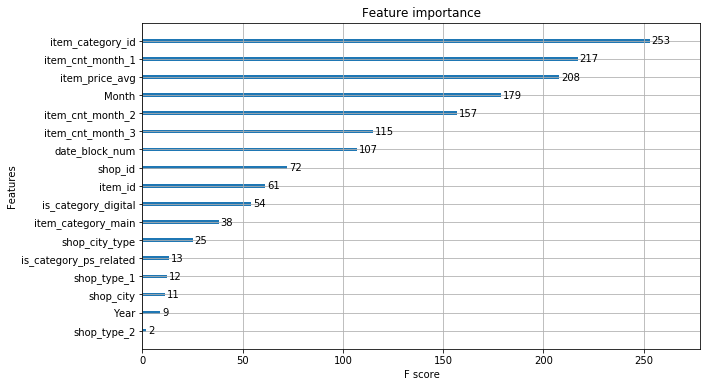

In [163]:
def plot_features(booster, figsize):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,6))

In [16]:
train_df.head()

,Month,Year,date_block_num,is_category_digital,is_category_ps_related,item_category_id,item_category_main,item_cnt_month,item_cnt_month_1,item_cnt_month_2,item_cnt_month_3,item_id,item_price_avg,shop_city,shop_city_type,shop_id,shop_type_1,shop_type_2
0,1,2013,0,0,0,40,10,0.0,0.0,0.0,0.0,19,28.0,0,0,2,1,1
1,1,2013,0,0,0,30,8,0.0,0.0,0.0,0.0,28,199.0,0,0,2,1,1
2,1,2013,0,0,0,23,5,0.0,0.0,0.0,0.0,29,1198.0,0,0,2,1,1
3,1,2013,0,0,0,40,10,0.0,0.0,0.0,0.0,32,149.0,0,0,2,1,1
4,1,2013,0,0,0,40,10,0.0,0.0,0.0,0.0,34,149.0,0,0,2,1,1


# Test DF

In [23]:
def add_lag(final_df, df):
    block33 = df[df['date_block_num'] == 33].copy()
    block33 = block33[['shop_id', 'item_id', 'item_cnt_month']]
    block33.rename(columns={"item_cnt_month": "item_cnt_month_1"}, inplace=True)
    final_df = pd.merge(final_df, block33,  how='left',
                         left_on = ['shop_id', 'item_id'],
                         right_on = ['shop_id', 'item_id'])
    final_df['item_cnt_month_1'] = final_df['item_cnt_month_1'].fillna(0)
    final_df = final_df.drop_duplicates()
    final_df = final_df.reset_index(drop=True)

    block32 = df[df['date_block_num'] == 32].copy()
    block32 = block32[['shop_id', 'item_id', 'item_cnt_month']]
    block32.rename(columns={"item_cnt_month": "item_cnt_month_2"}, inplace=True)
    final_df = pd.merge(final_df, block32,  how='left',
                        left_on = ['shop_id', 'item_id'],
                        right_on = ['shop_id', 'item_id'])
    final_df['item_cnt_month_2'] = final_df['item_cnt_month_2'].fillna(0)
    final_df = final_df.drop_duplicates()
    final_df = final_df.reset_index(drop=True)

    block31 = df[df['date_block_num'] == 31].copy()
    block31 = block31[['shop_id', 'item_id', 'item_cnt_month']]
    block31.rename(columns={"item_cnt_month": "item_cnt_month_3"}, inplace=True)
    final_df = pd.merge(final_df, block31,  how='left',
                        left_on = ['shop_id', 'item_id'],
                        right_on = ['shop_id', 'item_id'])
    final_df['item_cnt_month_3'] = final_df['item_cnt_month_3'].fillna(0)
    final_df = final_df.drop_duplicates()
    final_df = final_df.reset_index(drop=True)

    return final_df

In [156]:
def create_test_df():

    test = pd.read_csv("competitive-data-science-predict-future-sales/test.csv")
    test['date_block_num'] = 34
    test['Year'] = 2015
    test['Month'] = 11

    test = add_lag(test, train_df)

    # load shops and preprocess it
    shops = pd.read_csv("competitive-data-science-predict-future-sales/shops.csv")
    shops = fix_shops(shops)  # fix the shops as we have seen before

    # load item_category and preprocess it
    items_category = pd.read_csv("competitive-data-science-predict-future-sales/item_categories.csv")
    items_category = fix_item_category(items_category)

    # load items
    items = pd.read_csv("competitive-data-science-predict-future-sales/items.csv")
    items.drop(columns = ['item_name'], inplace = True)

    # merge data
    items_to_merge = items.merge(items_category, on = 'item_category_id')
    test_merged = test.merge(shops, on = 'shop_id', how = 'left')
    test_merged = test_merged.merge(items_to_merge, on = 'item_id', how = 'left')
    
    return test_merged


def add_price_col_to_test(test):
    
    # Algorithm:
    # 1. take the last price for the shop/item_id
    # 2. take the average price for the item_id
    # 3. take the median price for the category
    
    
    colnames = ['date_block_num', 'shop_id', 'item_id', 'Year', 'Month', 'shop_type_1',
       'shop_type_2', 'shop_city_type', 'shop_city', 'item_category_id',
       'item_category_main', 'is_category_digital', 'is_category_ps_related',
       'item_cnt_month_1', 'item_cnt_month_2', 'item_cnt_month_3',
       'item_price_avg']
    
    items = pd.read_csv("competitive-data-science-predict-future-sales/items.csv")
    sales_raw = pd.read_csv("competitive-data-science-predict-future-sales/sales_train.csv")
    sales_raw = adjust_duplicated_shops(sales_raw)

    last_price = sales_raw.sort_values(['shop_id','date_block_num'], ascending = [True, True])
    last_price = last_price.drop_duplicates(subset = ['shop_id','item_id'], keep = 'last')
    last_price = last_price[['shop_id','item_id','item_price']]
    last_price.columns = ['shop_id','item_id','item_price_avg']
    test_last_price = test.merge(last_price, on = ['shop_id','item_id'], how = 'left').dropna(subset = ['item_price_avg'])
    test_last_price_rest = test.loc[~test['ID'].isin(test_last_price['ID'])]

    mean_item_price = pd.DataFrame(sales_raw.groupby('item_id')['item_price'].median()).reset_index()
    mean_item_price.columns = ['item_id','item_price_avg']
    test_mean_item = test_last_price_rest.merge(mean_item_price, on = 'item_id', how = 'left').dropna(subset = ['item_price_avg'])
    id_list = list(test_mean_item['ID']) + list(test_last_price['ID'])
    test_mean_item_rest = test.loc[~test['ID'].isin(id_list)]

    sales_items = sales_raw.merge(items[['item_id','item_category_id']], on = 'item_id')

    median_item_cat_price = pd.DataFrame(sales_items.groupby('item_category_id')['item_price'].median()).reset_index()
    median_item_cat_price.columns = ['item_category_id','item_price_avg']

    test_category_price = test_mean_item_rest.merge(median_item_cat_price, on = 'item_category_id', how = 'left')

    test_with_price = pd.concat([test_last_price,test_mean_item,test_category_price], axis = 0)
    
    test_with_price.sort_values('ID', inplace = True)
    
    test_with_price.set_index('ID', inplace = True)
    
    test_with_price = test_with_price[colnames]
    
    return test_with_price


def apply_0_to_not_sold_categories(df):

    items = pd.read_csv("competitive-data-science-predict-future-sales/items.csv")
    sales_raw = pd.read_csv("competitive-data-science-predict-future-sales/sales_train.csv")
    sales_raw = adjust_duplicated_shops(sales_raw)
    merged_df = sales_raw.merge(items[['item_id','item_category_id']], on = 'item_id')

    all_item_categories = list(merged_df['item_category_id'].unique())

    not_available_categories_per_shop = {}

    for shop_id in merged_df['shop_id'].unique():
        shop_item_categories = list(merged_df.loc[merged_df['shop_id'] == shop_id,'item_category_id'].unique())
        not_available_categories_per_shop[shop_id] = list(set(all_item_categories) - set(shop_item_categories))
    
    counter = 0
    for key, value in not_available_categories_per_shop.items():
        counter += len(df.loc[(df['shop_id'] == key) & (df['item_category_id'].isin(value)), 'item_cnt_month'])
        df.loc[(df['shop_id'] == key) & (df['item_category_id'].isin(value)), 'item_cnt_month'] = 0
    
    print(counter)
    return df

In [44]:
test = create_test_df()

test_with_price = add_price_col_to_test(test)
test_with_price = downcast_dtypes(test_with_price)

In [189]:
test_with_price.head()

,date_block_num,shop_id,item_id,Year,Month,shop_type_1,shop_type_2,shop_city_type,shop_city,item_category_id,item_category_main,is_category_digital,is_category_ps_related,item_cnt_month_1,item_cnt_month_2,item_cnt_month_3,item_price_avg,item_cnt_month
ID,,,,,,,,,,,,,,,,,,
0,34,5,5037,2015,11,3,2,0,3,19,5,0,1,0.0,1.0,3.0,749.5,0.560716
1,34,5,5320,2015,11,3,2,0,3,55,12,0,0,0.0,0.0,0.0,299.0,0.077744
2,34,5,5233,2015,11,3,2,0,3,19,5,0,1,1.0,3.0,1.0,1199.0,0.943951
3,34,5,5232,2015,11,3,2,0,3,23,5,0,0,0.0,0.0,1.0,599.0,0.288923
4,34,5,5268,2015,11,3,2,0,3,20,5,0,1,0.0,0.0,0.0,2799.0,0.693795


In [165]:
y_pred = model.predict(test_with_price)

test_with_price['item_cnt_month'] = y_pred.clip(0, 20)
test_with_price = apply_0_to_not_sold_categories(test_with_price)

prediction_df = test_with_price[['item_cnt_month']].reset_index()

In [188]:
prediction_df.to_csv('solution_xgboost.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
